In [3]:
import pandas as pd
import seaborn as sns
import new_utils
import new_plots
import glob, os

import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [9]:
hela_files = glob.glob('../data/HeLa/*.xlsx')
hela_files

['../data/HeLa/NAD_raw_2.xlsx',
 '../data/HeLa/NAD_raw_3.xlsx',
 '../data/HeLa/NAD_raw_1.xlsx']

## Isotopolog correction

In [19]:
def iso_correction(hela_files=hela_files, met='NAD', xcol='time', threshold=0.01,
                   growth_correction=False, transform=None, columns=['cell type', 'time', 'replicate number'],
                   cell_column='cell type'):
    df_isocorr = pd.DataFrame()
    for file in hela_files:
        df_raw = pd.read_excel(file)
        df_raw['time'] = df_raw['time point (h)']
        _df_isocorr = new_utils.get_iso_corr(df_raw=df_raw, met=met, xcol=xcol, threshold=threshold,
                                            growth_correction=growth_correction, transform=transform,
                                            columns=columns, cell_column=cell_column)
        df_isocorr = pd.concat([df_isocorr, _df_isocorr])
    return df_isocorr

df_isocorr = iso_correction(hela_files=hela_files)
df_isocorr

cell line: HeLa  |  met: NAD  |  threshold: 0.1


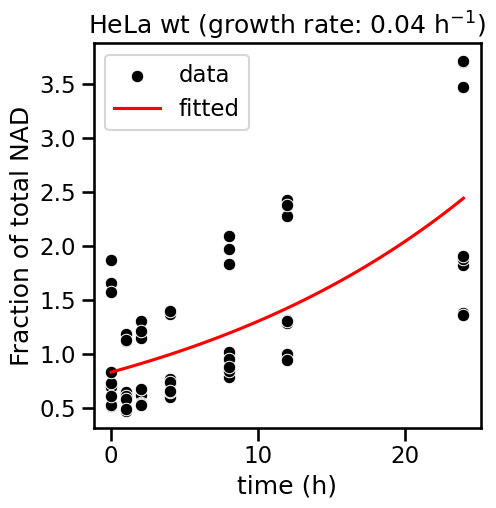

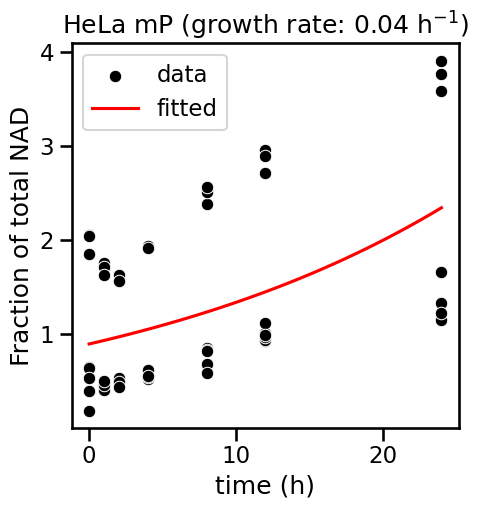

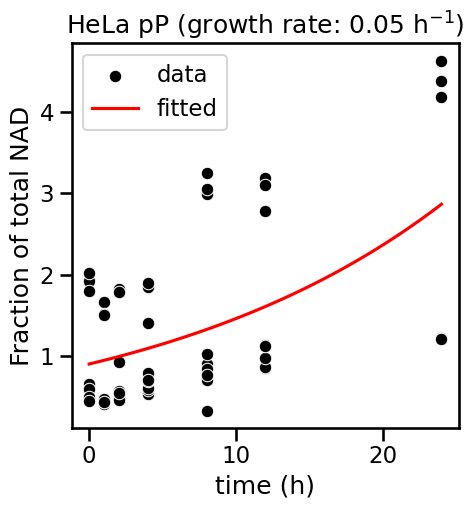

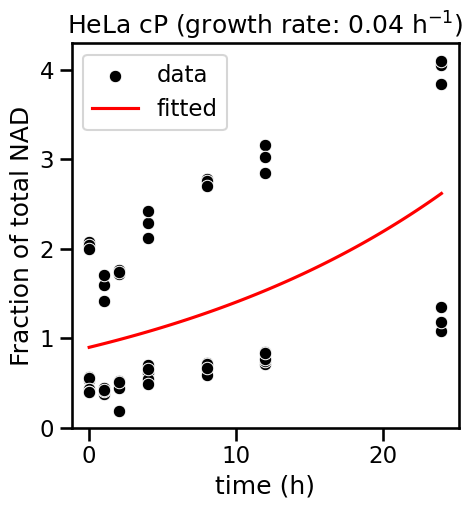

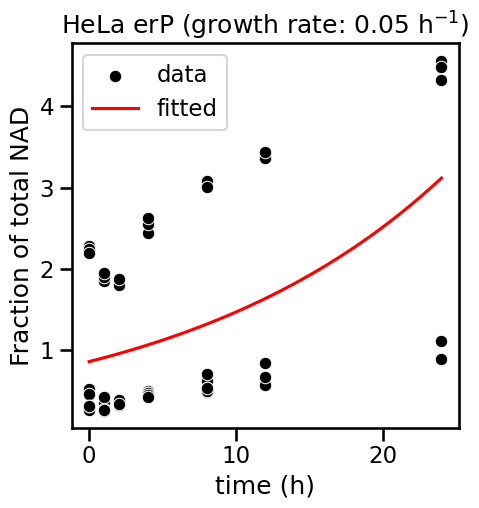

In [20]:
sns.set_context('talk', font_scale=1.0)
met = 'NAD'
threshold = 0.1
cell_line = 'HeLa'
print(f'cell line: {cell_line}  |  met: {met}  |  threshold: {threshold}')
growth_correction = False

iso_corr_all = iso_correction(hela_files=hela_files, met=met, threshold=threshold, 
                              growth_correction=growth_correction, transform=None)
list_of_mets = [i for i in iso_corr_all.columns if i.split('_')[0] == met]
gpars = new_utils.estimate_growth_parameters(iso_corr_all, list_of_mets=list_of_mets, 
                                             cell_line=cell_line, met=met)

## NAD decay plots

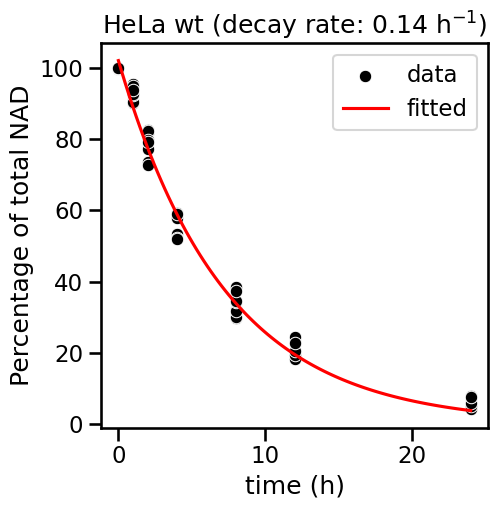

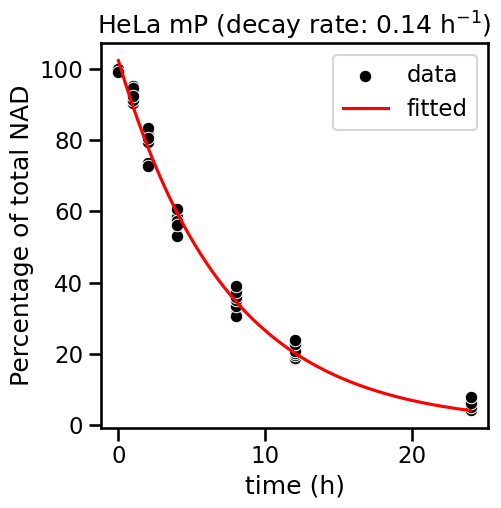

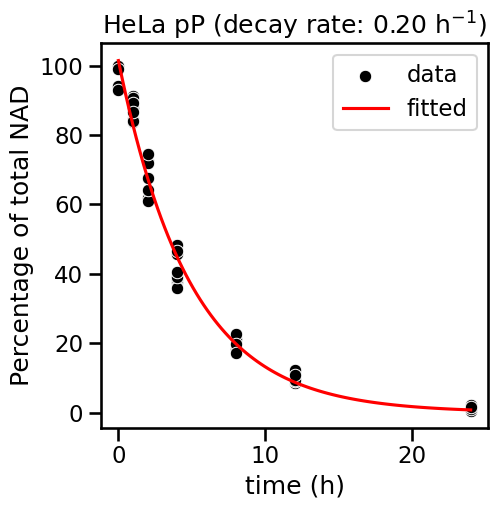

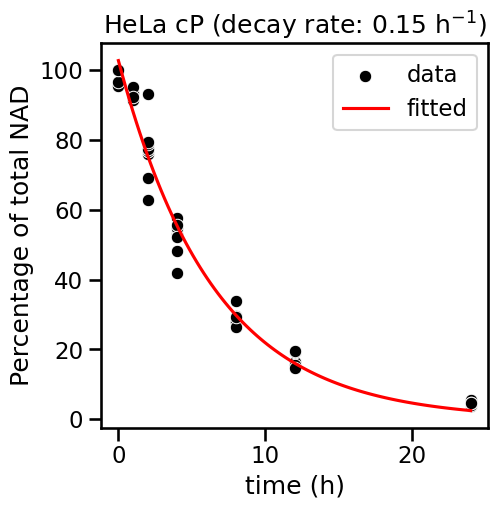

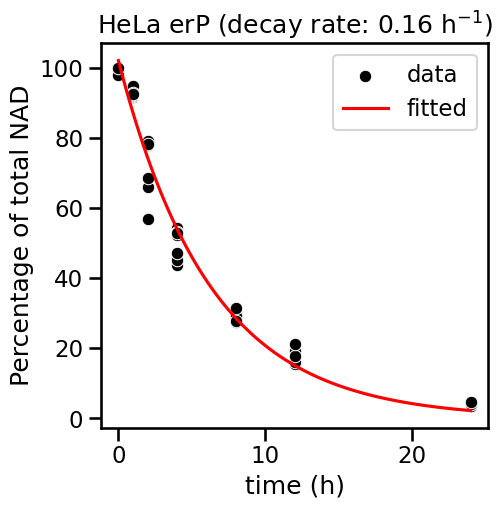

In [21]:
# Estimate decay parameters
sns.set_context('talk', font_scale=1.0)

cell_line = 'HeLa'
met = 'NAD'
save_fig = False
show_fig = True
save_data = False

growth_correction = True

all_data = iso_correction(hela_files=hela_files, met=met, threshold=threshold, 
                          growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == met]
dpars = new_utils.estimate_decay_parameters(iso_corr_percent=all_data, cell_line=cell_line, 
                                            xcol='time', ycol=met)

## Fig S3: Percentage labelled and unlabelled individual plots

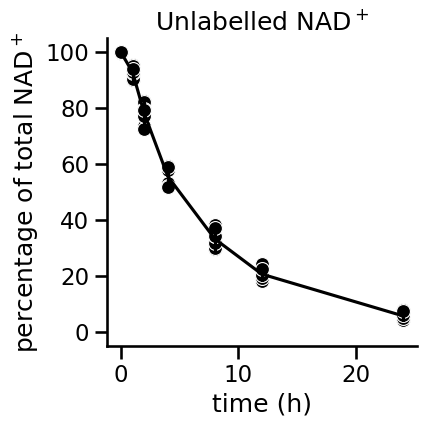

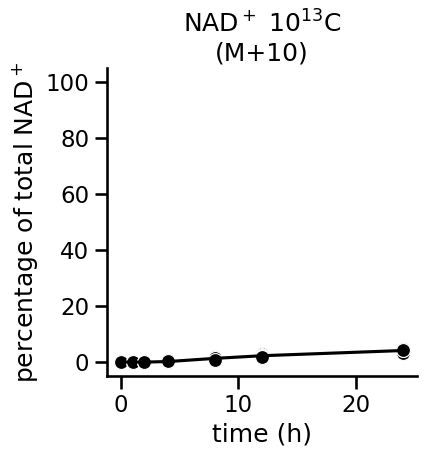

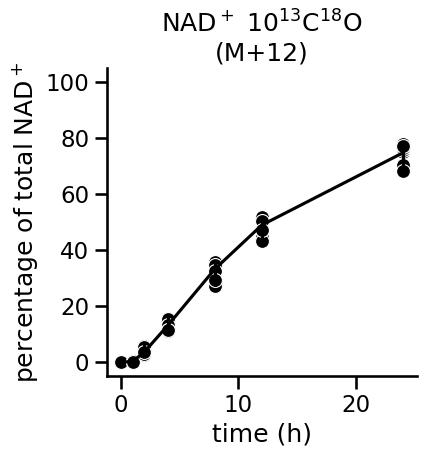

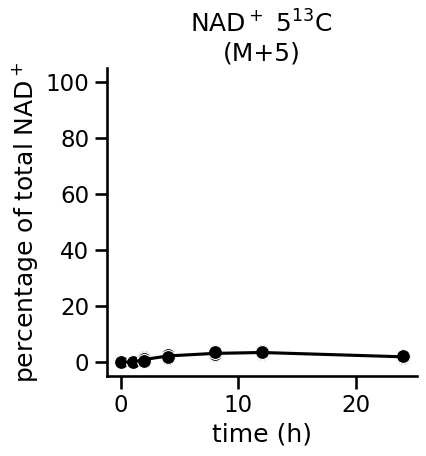

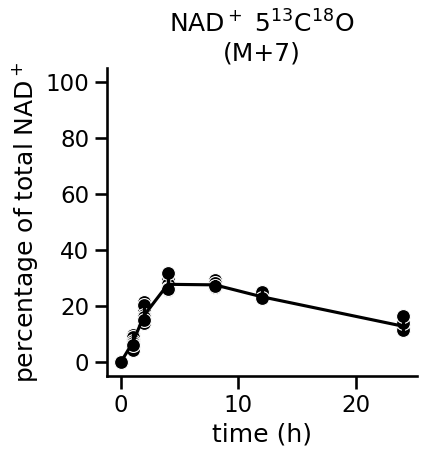

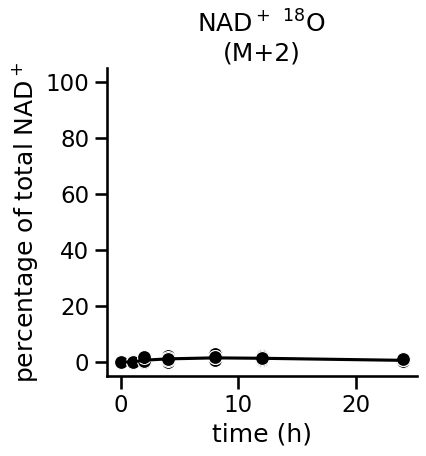

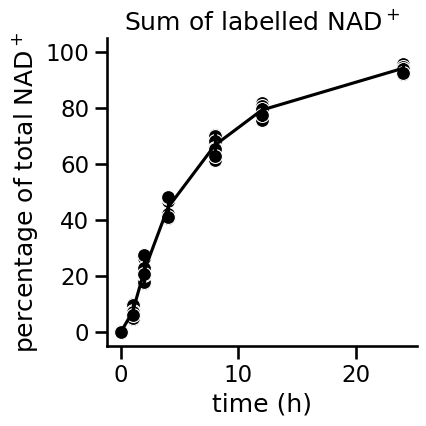

In [29]:
sns.set_context('talk', font_scale=1.0)

cell_line = 'HeLa'
met = 'NAD'
save_data = False
save_fig = False
show_fig = True
file = None
threshold = 0.1

growth_correction = True

all_data = iso_correction(hela_files=hela_files, met=met, threshold=threshold,
                          growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == met]
all_data['sum labelled'] = all_data[list_of_mets[1:]].sum(axis=1)
_df = all_data[all_data['cell type'] == cell_line+ ' wt']
new_plots.plot_fig3_panel_b(iso_corr_percent=_df, list_of_mets=list_of_mets, 
                            cell_line=cell_line, met=met, 
                            growth_correction=growth_correction)

## Fig S3f: Unlabelled and sum labelled components plot

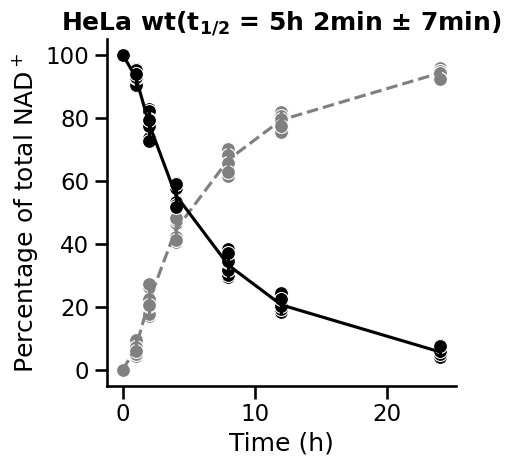

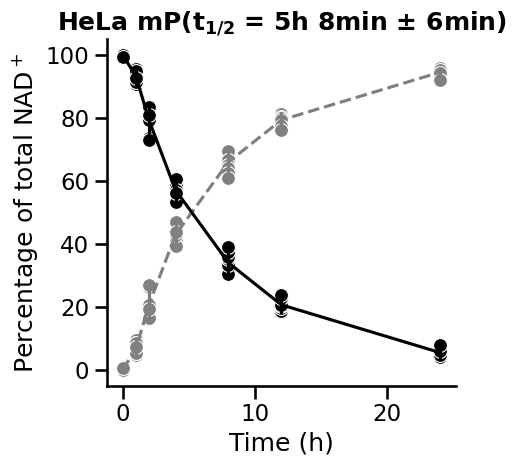

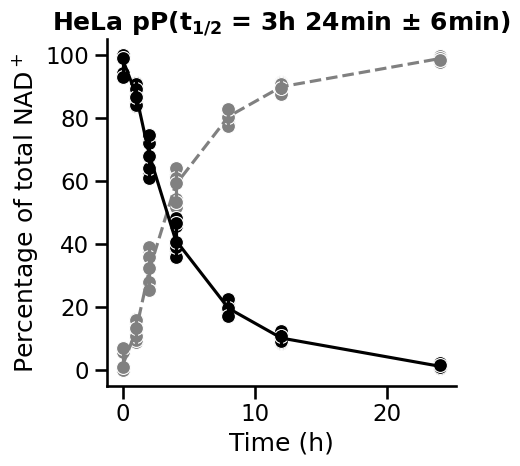

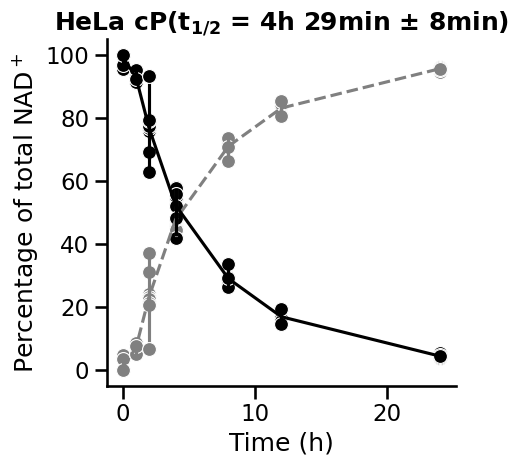

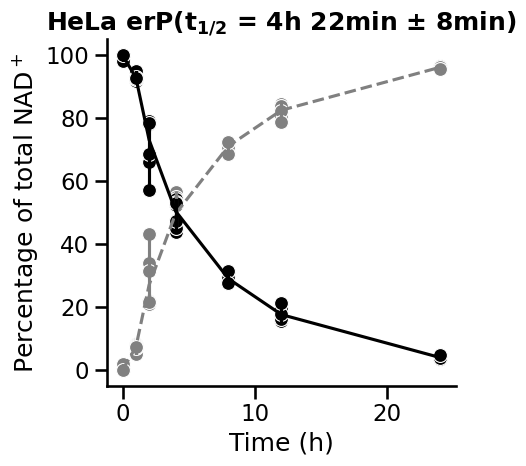

In [31]:
sns.set_context('talk', font_scale=1.0)

cell_line = 'HeLa'
met = 'NAD'
files = hela_files
growth_correction = True

all_data = iso_correction(hela_files=files, met=met, threshold=threshold,
                          growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == met]
all_data['sum labelled'] = all_data[list_of_mets[1:]].sum(axis=1)
dpars = new_utils.unlabelled_and_sum_labelled(iso_corr_percent=all_data, cell_line=cell_line, xcol='time', ycol2=met,
                                       ycol='sum labelled', growth_correction=growth_correction, met=met,
                                       ylabel=f'Percentage of total NAD$^+$')

,t-statistic,p-value
HeLa_cP,1.286799,0.234148
HeLa_erP,2.218140,0.057348
HeLa_mP,4.033458,0.003770
HeLa_pP,2.790194,0.023551
cP_erP,2.895226,0.020038
cP_mP,4.324700,0.002530
cP_pP,3.254891,0.011616
erP_mP,1.528064,0.165018
erP_pP,0.911485,0.388680
mP_pP,0.313181,0.762152


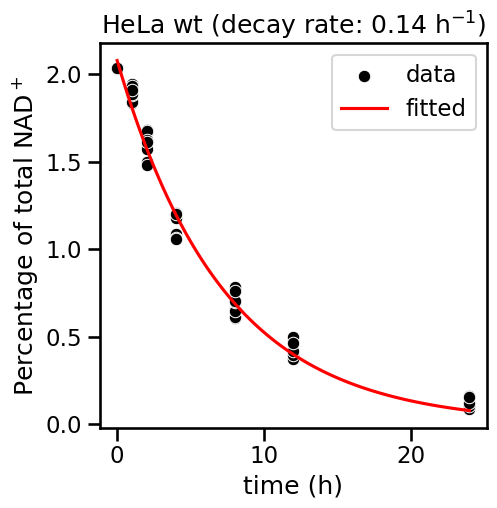

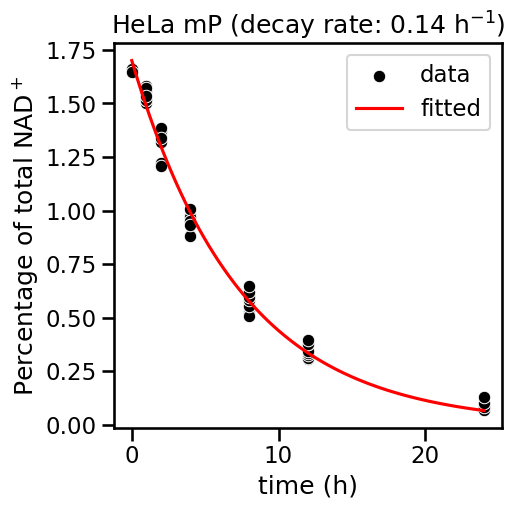

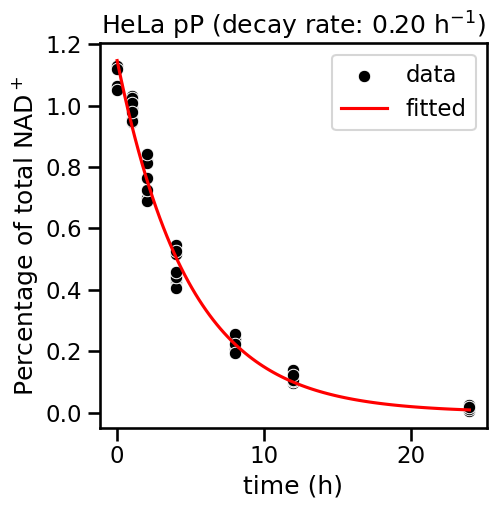

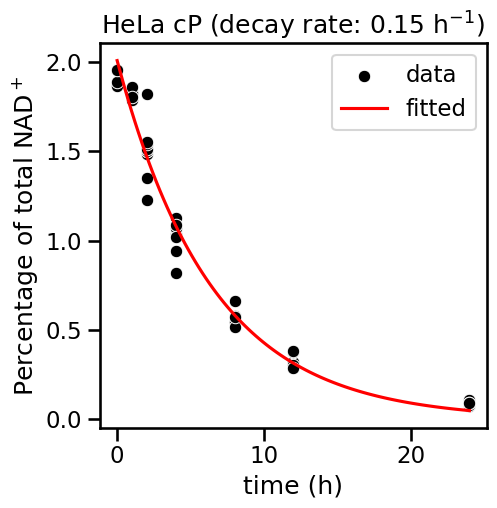

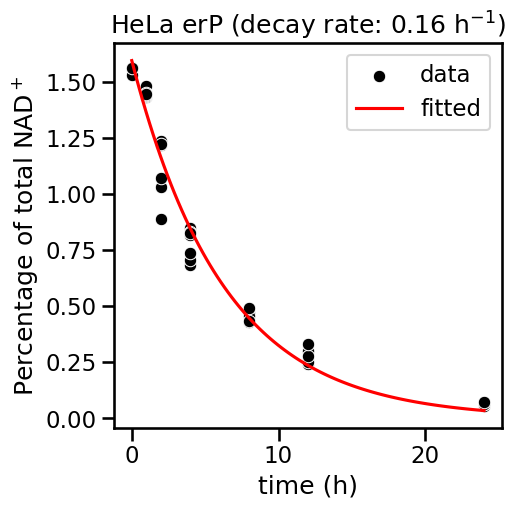

In [42]:
growth_correction = True
cell_line = 'HeLa'

all_data = iso_correction(hela_files=hela_files, met='NAD', threshold=0.1,
                            growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == 'NAD']
all_data['sum labelled'] = all_data[list_of_mets[1:]].sum(axis=1)
all_data['cell type'] = all_data['cell type'].map({'HeLa wt': 'HeLa',
                          'HeLa mP': 'mP',
                          'HeLa pP': 'pP',
                          'HeLa cP': 'cP',
                          'HeLa erP': 'erP'})

nad_conc = pd.read_csv('../data/nad_conc_new.csv', index_col=0)
nad_conc = nad_conc[nad_conc['cell line'] == cell_line]
dpars = new_utils.estimate_turnover(iso_corr_percent=all_data, nad_conc=nad_conc, cell_line=cell_line,
                             xcol='time', ycol='pool_corr_unlabelled',
                             default_path='./publication/', save_data=False,
                             file=None, per_experiment=False, growth_correction=growth_correction)
df_stat = new_utils.calculate_t_stats(dpars, n_samples=9)
df_stat

In [43]:
dpars

,cell type,growth_rate,growth_rate_standard_error,prefactor_growth,prefactor_growth_standard_error,prefactor_decay,decay_rate,prefactor_decay_error,decay_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
0,HeLa,0.042143,0.002672,0.886184,0.038149,2.078971,0.137764,0.016965,0.002982,5.031407,0.108893,2.036667,0.015275,0.202395,0.013645
1,cP,0.038570,0.003542,0.958472,0.044335,2.007582,0.154326,0.023334,0.004645,4.491451,0.135192,1.956667,0.066583,0.217821,0.022319
2,erP,0.046489,0.004089,0.961610,0.043507,1.596408,0.158981,0.018887,0.005031,4.359934,0.137979,1.563333,0.047258,0.179284,0.017613
3,mP,0.039766,0.003073,0.989462,0.050658,1.700268,0.135234,0.013243,0.002802,5.125541,0.106194,1.660000,0.103923,0.161934,0.016450
4,pP,0.043780,0.005118,0.955323,0.064428,1.146660,0.203995,0.012545,0.005556,3.397871,0.092537,1.130000,0.104403,0.166281,0.025186
